# Experiment Analysis

In [270]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

color_lst = [ '#059ff6', '#475d70', '#f22e92', '#7565df', '#8fd5fa', '#0c385b', '#a1c1ea']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_lst) 

from math import ceil

from scipy import stats
from statsmodels.stats import weightstats
from statsmodels.stats.power import TTestIndPower



In [271]:
experiment = pd.read_csv('../data/analytical_take_home_data_v3.csv')
experiment.head()

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018


In [272]:
# rename column for visualization and labeling
treatment_mapping_dict = {True:'treatment', False:'control'}
experiment.insert(loc=0, column='version', value=experiment.treatment.map(treatment_mapping_dict))

experiment.drop('treatment', axis=1, inplace=True)

In [273]:
# Data is collected from 15,474 campaigns with the experimentation conducted randomly splitting advertisers 
# to test the new product
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   version          15474 non-null  object 
 1   company_size     15474 non-null  object 
 2   campaign_spend   15474 non-null  float64
 3   campaign_budget  15474 non-null  float64
dtypes: float64(2), object(2)
memory usage: 483.7+ KB


### Experimentation and Data Schema Summary

A/B Testing Result <br>
**Experiment**: pay each time ads appears in a user’s viewport rather than each time a user clicks on ads. (CTR vs Impressions)<br>

<br>


1) treatment 
- true = new product (pay on impressions)
- false = old product (pay on clicks)

2) company size
- small: local businesses 
- medium: small national brands
- large: global brands 

3) campaign spend & campaign budget: amount budgeted by the advertizers and spent by Twitter in the time of the experiment


**Goal**: effectiveness of the new product

In [274]:
# Overspend: the amount that Twitter has to cover for ad spend that exceeded the campaign's budget. 
# if spending remains within the budget, Twitter will not incur any additional overspend expense (hence, $0)

experiment['overspend_amt'] = experiment.campaign_spend - experiment.campaign_budget
experiment['overspend_amt'] = experiment.overspend_amt.clip(lower=0)
experiment['overspend'] = experiment.overspend_amt > 0 

In [275]:
experiment.head()

,version,company_size,campaign_spend,campaign_budget,overspend_amt,overspend
0,control,small,10.4477,3.9035,6.5442,True
1,control,medium,3.7776,1.9872,1.7904,True
2,control,medium,46.1880,55.4523,0.0000,False
3,control,small,6.6271,6.5136,0.1135,True
4,control,small,92.3405,83.1018,9.2387,True


## Experiment EDA

In [276]:
experiment_count = experiment.version.value_counts()
experiment_count

treatment    7741
control      7733
Name: version, dtype: int64

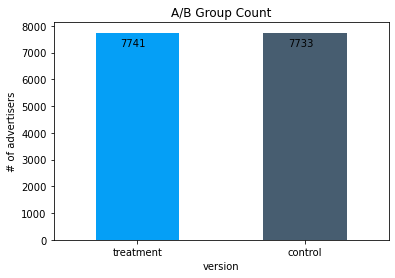

In [277]:
ax = experiment_count.plot(kind='bar', color=color_lst[:2], title='A/B Group Count',
                          xlabel='version', ylabel='# of advertisers')

ax.set_xticklabels(['treatment', 'control'], rotation=0)


for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + 0.15, p.get_height() - 500))

fig = ax.get_figure()
fig.savefig('../images/ab_count')

In [278]:
experiment_prop = experiment.version.value_counts(normalize=True)
experiment_prop

treatment    0.500258
control      0.499742
Name: version, dtype: float64

In [279]:
# The medium company size category is undersampled relative to the small and large-sized advertisers. 
# Could this be based on their abundance in the population?  
# Or are they undersampled based on the different factors during the experimentation? 

company_size_prop = experiment.company_size.value_counts(normalize=True)
company_size_prop

small     0.575223
large     0.332558
medium    0.092219
Name: company_size, dtype: float64

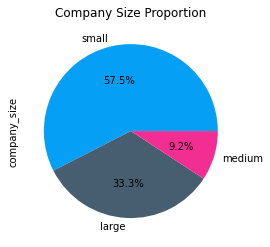

In [280]:
ax = company_size_prop.plot(kind='pie', autopct='%1.1f%%', title='Company Size Proportion')

fig = ax.get_figure()
fig.savefig('../images/company_size_pie');

In [206]:
company_size_prop_ab = pd.crosstab(experiment.company_size, experiment.version, normalize='index')
company_size_prop_ab

version,control,treatment
company_size,,
large,0.524874,0.475126
medium,0.515067,0.484933
small,0.482755,0.517245


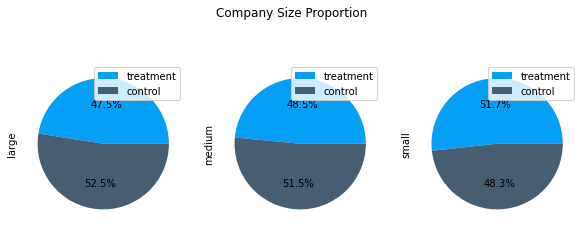

In [207]:
# there is a slight imbalance in the split between the treatment group and the control group, particularly 
# in the large company size category

ax = company_size_prop_ab[['treatment', 'control']].T.plot(kind='pie', autopct='%1.1f%%', title='Company Size Proportion', subplots=True, 
                           figsize=(10,4), labeldistance=None)


In [208]:
company_size_count_ab = pd.crosstab(experiment.company_size, experiment.version)
company_size_count_ab

version,control,treatment
company_size,,
large,2701,2445
medium,735,692
small,4297,4604


''

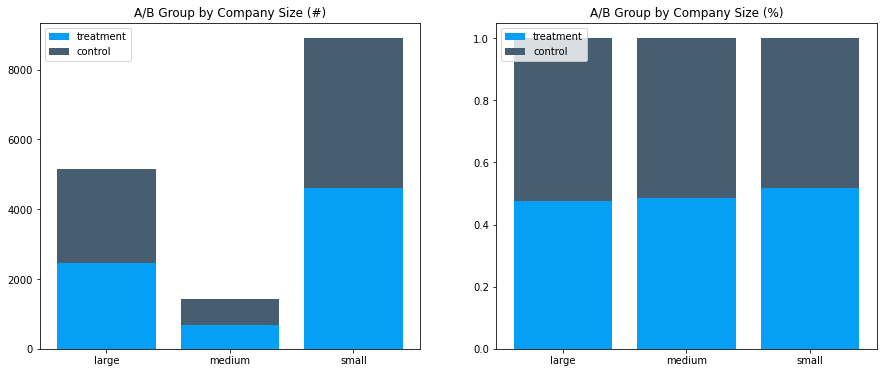

In [209]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

for idx, (df_summary, sign) in enumerate(zip([company_size_count_ab, company_size_prop_ab], ['#', '%'])):
    axs[idx].bar(df_summary.index, df_summary.treatment, label='treatment')
    axs[idx].bar(df_summary.index, df_summary.control, bottom=df_summary.treatment, 
           label='control')

    axs[idx].set_title(f'A/B Group by Company Size ({sign})')
    axs[idx].legend(loc='upper left')
    

fig.savefig(f'../images/ab_by_company_size.jpg')

;


In [210]:
experiment.describe().apply(lambda d: d.apply('{0:.1f}'.format))

,campaign_spend,campaign_budget,overspend_amt
count,15474.0,15474.0,15474.0
mean,4903.0,5772.6,341.5
std,65166.9,99033.8,4079.1
min,0.4,0.1,0.0
25%,15.2,12.8,0.1
50%,50.1,48.8,2.2
75%,236.5,252.3,7.8
max,5289216.9,10242888.2,288590.2


In [211]:
def plot_distribution(ab_df, col_name, title, separation_quantile):
    
#     print(f'The separation frequency is at {ab_df[col_name].quantile(separation_quantile):.1f}')
    
    fig, axs = plt.subplots(2, 2, figsize=(12,8), tight_layout=True)
    
    for idx, version in enumerate(['treatment', 'control']):
        df = ab_df[ab_df.version == version]


        # create a new dataframe with the data below than the separation quantile of the given column 
        lower_bound_dist = df[col_name][(df[col_name] < df[col_name].quantile(separation_quantile))]

        # create another dataframe with the data higher than the separation quantile of the given column 
        upper_bound_dist = df[col_name][(df[col_name] >= df[col_name].quantile(separation_quantile))]


        


        # plot the lower bound distribution and median
        axs[0,idx].hist(lower_bound_dist, color=color_lst[idx]) 
        axs[0,idx].axvline(df[col_name].quantile(0.5), color='black', ls='--', 
                      label=f'median = {df[col_name].median():.1f} \n (mean = {df[col_name].mean():.1f})')
        axs[0,idx].set_ylabel('frequency')
        axs[0,idx].set_xlabel(col_name)
        axs[0,idx].set_title(f'{separation_quantile*100:.0f}% of the Data Distribution', fontsize=14)
        axs[0,idx].legend()

        # plot the upper bound distribution and mean    
        axs[1,idx].hist(upper_bound_dist, color=color_lst[idx])
        axs[1,idx].axvline(df[col_name].mean(), color='black', ls='--', 
                      label=f'mean = {df[col_name].mean():.1f}', alpha=0.5)

        axs[1,idx].set_ylabel('frequency')
        axs[1,idx].set_xlabel(col_name)
        axs[1,idx].set_title(f'{100-separation_quantile*100:.0f}% of the Tail Data Distributiion', fontsize=14)
        axs[1,idx].legend()
    
    fig.suptitle(title + ' Treatment vs Control Group', fontsize=14)
    
    fig.savefig(f'../images/{col_name}_distribution.jpg')
    ;


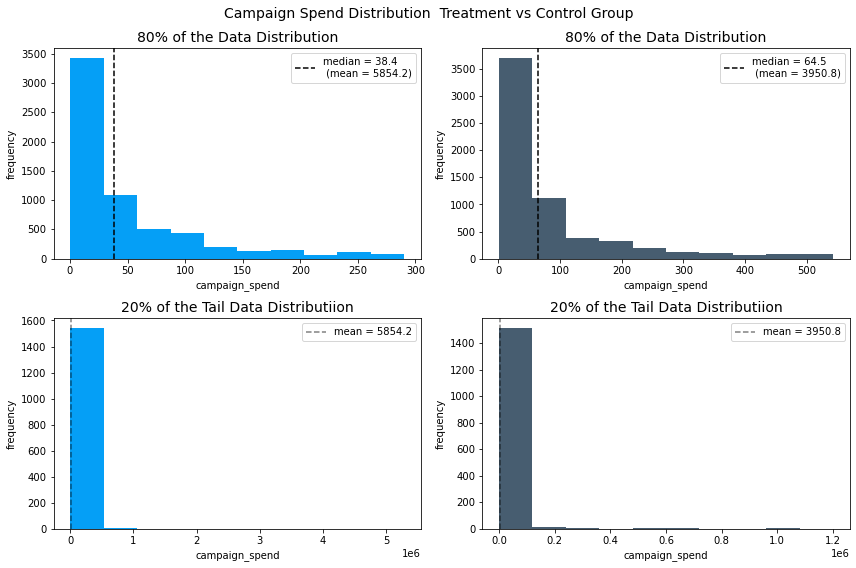

In [212]:
plot_distribution(experiment, 'campaign_spend', title='Campaign Spend Distribution ',
                  separation_quantile=0.8)

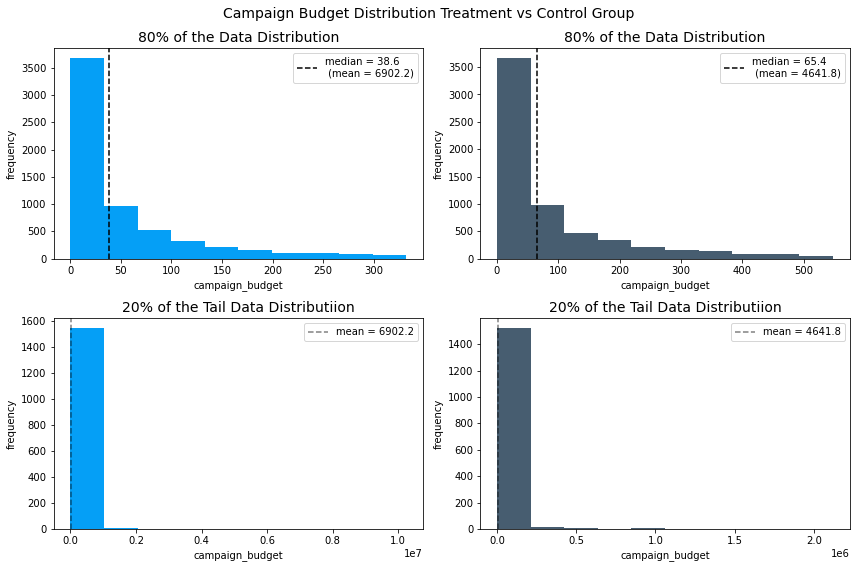

In [213]:
plot_distribution(experiment, 'campaign_budget', title='Campaign Budget Distribution', separation_quantile=0.8)

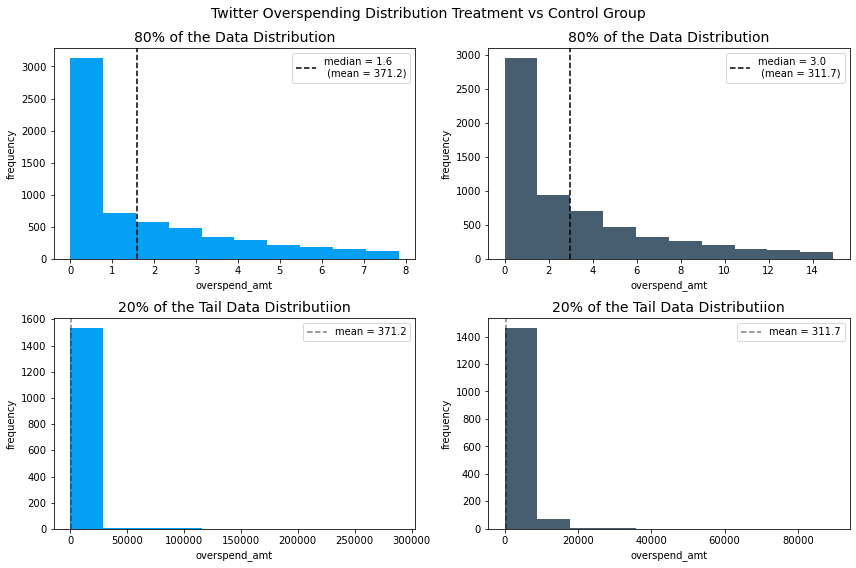

In [214]:
plot_distribution(experiment, 'overspend_amt', title='Twitter Overspending Distribution', separation_quantile=0.8)

In [215]:
# Adding a new feature over budget spend percentage to assess overspend

experiment['overbudget_pct'] = experiment.overspend_amt / experiment.campaign_budget * 100

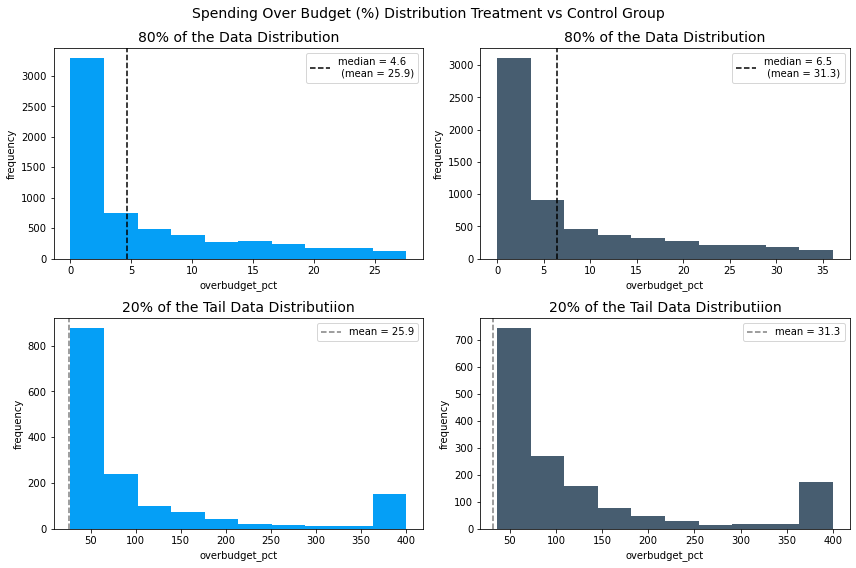

In [216]:
plot_distribution(experiment, 'overbudget_pct', title='Spending Over Budget (%) Distribution', 
                  separation_quantile=0.8)

## [Part 2. Q1.] No of Campaigns with ≥ 1% Overbudget

In [217]:
experiment_count[['control', 'treatment']]

control      7733
treatment    7741
Name: version, dtype: int64

In [218]:
overpend_greater_1pct = (
    experiment[(experiment.overbudget_pct > 1)]
    .groupby('version')
    .agg(
        gt_1pct_overbudget_count=('overspend', 'count'),
        avg_overspend_pct=('overbudget_pct', 'mean'),
    )
)

overpend_greater_1pct


,gt_1pct_overbudget_count,avg_overspend_pct
version,,
control,5716,42.330107
treatment,5180,38.705676


In [219]:
overpend_greater_1pct.sum()[0] / experiment_count.sum() 

0.7041488949205118

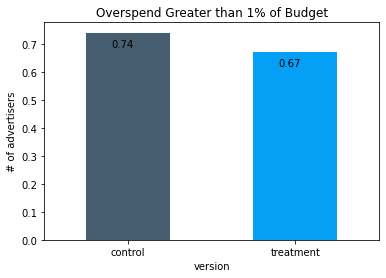

In [220]:
overpend_greater_1pct_proportion = overpend_greater_1pct['gt_1pct_overbudget_count'] \
                                    / experiment_count[['control', 'treatment']]

ax = overpend_greater_1pct_proportion.plot(kind='bar', color=color_lst[:2][::-1], 
                                           title='Overspend Greater than 1% of Budget',
                                            xlabel='version', ylabel='# of advertisers')

ax.set_xticklabels(['control', 'treatment'], rotation=0)

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),2) , (p.get_x() + 0.15,  p.get_height() - 0.05))

fig = ax.get_figure()
fig.savefig('../images/1pct_prop')

Of the 10.9K (5716 in control and 5180 in treatment group) campaigns with overspend of greater than 1% of their budget, with the following averages:
- control group has a 42.3% average overage on budget  while 
- treatment group has a 38.7% average overage


The below table shows the 1% greater than budget overspend campaigns further broken by company size:

In [221]:
overpend_greater_1pct_by_companysize = (
    experiment[(experiment.overbudget_pct > 1)]
    .groupby(['version', 'company_size'])
    .agg(
        gt_1pct_overbudget_count=('overspend', 'count'),
        avg_overbudget_pct=('overbudget_pct', 'mean'),
        avg_overspend_amt=('overspend_amt', 'mean'),
        total_overspend_amt=('overspend_amt', 'sum'),
    )
)

overpend_greater_1pct_by_companysize = overpend_greater_1pct_by_companysize.apply(
    lambda d: d.apply("{0:.0f}".format)
)

overpend_greater_1pct_by_companysize


gt_1pct_overbudget_count avg_overbudget_pct  \
version   company_size                                               
control   large                            1875                 28   
          medium                            452                 21   
          small                            3389                 53   
treatment large                            1504                 21   
          medium                            414                 25   
          small                            3262                 49   

                       avg_overspend_amt total_overspend_amt  
version   company_size                                        
control   large                      781             1463808  
          medium                     224              101323  
          small                      247              837792  
treatment large                      704             1059051  
          medium                     389              161186  
          small                      497             1620581

## [Part 2. Q2.] Effectiveness of New Product

In [222]:
# shows the number of campaigns from each variant, 7733 in control and 7741 in treatment
# as we recall above, with a ratio of 49.97% and 50.02% respectively. 
experiment_count

treatment    7741
control      7733
Name: version, dtype: int64

In [223]:
sample_size_per_variant = ceil(experiment.shape[0]/2)
sample_size_per_variant

7737

### Sample Ratio Mismatch Hypothesis Testing

We will do a Chi-Square Goodness of Fit Test to decide if Decide if one variable is likely to come from a given distribution or not. 

$H_0$: proportion of treatment groups are the same <br>

$H_a$: proportions of treatment groups are not the same

With alpha set at 0.1% and degrees of freedom at 1 (no of categories - 1), therfore delta degrees of freedom as 0

In [224]:
stats.chisquare(f_obs=experiment_count.values, f_exp=[sample_size_per_variant, sample_size_per_variant],
                ddof=0)

Power_divergenceResult(statistic=0.004135970014217397, pvalue=0.9487221906574269)

The one-way chi-square test tests for Sample Ratio Mismatch. Since the p-value is 0.95, we fail to reject the null hypothesis and conclude **no evidence of SRM**. In other words, treatment assignment works as expected.


In [225]:
experiment.head()

,version,company_size,campaign_spend,campaign_budget,overspend_amt,overspend,overbudget_pct
0,control,small,10.4477,3.9035,6.5442,True,167.649545
1,control,medium,3.7776,1.9872,1.7904,True,90.096618
2,control,medium,46.1880,55.4523,0.0000,False,0.000000
3,control,small,6.6271,6.5136,0.1135,True,1.742508
4,control,small,92.3405,83.1018,9.2387,True,11.117328


In [226]:
experiment_summary = experiment.groupby(['version']).agg(count = ('overspend', 'count'),
                                    overspend_count=('overspend', 'sum'),
                                    overspend_prop = ('overspend', 'mean'),
                                    avg_overspend_amt = ('overspend_amt', 'mean'),
                                    avg_campaign_spend = ('campaign_spend', 'mean'),
                                    avg_campaign_budget= ('campaign_budget', 'mean'),
                                    avg_overbudget_pct = ('overbudget_pct', 'mean')
                                            ).apply(
                                lambda d: d.apply("{0:.2f}".format))

experiment_summary

,count,overspend_count,overspend_prop,avg_overspend_amt,avg_campaign_spend,avg_campaign_budget,avg_overbudget_pct
version,,,,,,,
control,7733.00,6257.00,0.81,311.74,3950.85,4641.83,31.32
treatment,7741.00,5721.00,0.74,371.20,5854.24,6902.23,25.93


- Surface level, the treatment group has a lower overspend ratio (0.77) than the control (0.80). Is the difference significant?
- To what extent can the result be trusted?
- Referencing the frequentist theory, if we repeat the process a large number of times, how many times do we obtain more extreme values? 

## Difference in Overspend Proportion Hypothesis Testing

### Stratified Random Sampling

In [227]:
def generate_boootstrap_sample_stats(
    df, 
    col_to_evaluate,  
    n_bootstrap_samples=10000,
    level=0, 
    stat = 'mean',
    **kwargs): 
    
    '''
       Generate bootstrap sample stats for the given column to evaluate. 

        Parameters
        ----------
        df: DataFrame
          The raw DataFrame from the A/B test experimentation.
          
        col_to_evaluate: str
          Name of the column for evaluation.
          
        n_bootstrap_samples: int, default=10000
          The number of times bootstrap samples should be generated.
          
        level: {0, 1}, default=0
          0 yields stratified bootstrap samples based on stratification proportions and sample size per variant.
          1 yields randomly sampled bootstraps based on the given company size filter.
          
        stat: {'mean', 'variance'}, default='mean'
          Sample statistics to calculate.
          
        **kwargs
        strata_proportions: lst
          Population proportion (or estimation) for the company size categories 
          [small_proportion, medium_proportion, large_proportion]. 
          
        sample_size: int
          The ideal number of campaigns in each variant.
          
        company_size: {'small', 'medium', 'large'}
          The company size category. 
        

        Returns
        -------
        boootstrap_sample_stats: DataFrame
          Returns a DataFrame with each record corresponding to a single boostrap sample with 
          the following attributes:
          - control_size: Count of records in the control group
          - treatment_size: Count of records in the treatment group
          - control: Sample stat for the control group
          - treatment: Sample stat for the treatment group
        
        
    '''
    
    bootstrap_sample_stats = []
    
    if level == 0:
        strata_proportions = kwargs['strata_proportions']
        sample_size = kwargs['sample_size']
        
        small_df = df.company_size[df.company_size == 'small']
        medium_df = df.company_size[df.company_size == 'medium']
        large_df = df.company_size[df.company_size == 'large']
        
    elif level == 1:
        company_size = kwargs['company_size']
        sub_df = df.company_size[df.company_size == company_size]
        size = df.groupby('company_size')['company_size'].agg('count')[company_size]
    

    
    for i in range(n_bootstrap_samples):
        if level == 0:
            stratified_idx = list(small_df.sample(int(sample_size*strata_proportions[0])*2, replace=True).index) \
                     + list(medium_df.sample(int(sample_size*strata_proportions[1])*2, replace=True).index) \
                     + list(large_df.sample(int(sample_size*strata_proportions[2])*2, replace=True).index)

        elif level == 1:
            stratified_idx = list(sub_df.sample(int(size), replace=True).index)
        
        stratified_bootstrap_sample = df.loc[stratified_idx,:]
        
        control_result = stratified_bootstrap_sample[stratified_bootstrap_sample.version == 'control']
        treatment_result = stratified_bootstrap_sample[stratified_bootstrap_sample.version == 'treatment']
#         t_stat, p_val = stats.ttest_ind(control_result[col_to_evaluate], treatment_result[col_to_evaluate])
        
        if stat == 'mean':
            bootstrap_result = {'control_size' : control_result.shape[0],
                                'treatment_size' : treatment_result.shape[0],
                                'control': control_result[col_to_evaluate].mean(),
                                'treatment': treatment_result[col_to_evaluate].mean()}

            bootstrap_sample_stats.append(bootstrap_result)
        elif stat == 'variance':
            bootstrap_result = {'control_size' : control_result.shape[0],
                                'treatment_size' : treatment_result.shape[0],
                                'control': control_result[col_to_evaluate].var(),
                                'treatment': treatment_result[col_to_evaluate].var()}

            bootstrap_sample_stats.append(bootstrap_result)

        
    return pd.DataFrame(bootstrap_sample_stats)




### Difference in Proportion

In [228]:
power = 0.8
alpha = 0.05

analysis = TTestIndPower()

effect_size = analysis.solve_power(nobs1=sample_size_per_variant, power=power, ratio=1, alpha=alpha, 
                                   alternative='smaller')
np.round(effect_size,2)

-0.04

In [229]:
effect_size * float(experiment_summary.overspend_prop['control'])

-0.03238316310126215

$H_0$: $p_{control}$ - $p_{treatment}$ ≤ 0.032 <br>
$H_a$: $p_{control}$ - $p_{treatment}$ > 0.032

In other words, 
$H_a$: $p_{treatment}$ - $p_{control}$ < -0.032, is the effect size we want to detect.

In [230]:
experiment_stratified = generate_boootstrap_sample_stats(
    df=experiment, 
    col_to_evaluate='overspend',  
    n_bootstrap_samples=100,
    level=0, 
    stat = 'mean',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])

experiment_stratified.mean().map('{:.2f}'.format)

control_size      7848.77
treatment_size    7625.23
control              0.78
treatment            0.72
dtype: object

In [231]:
def compute_se_diff_in_proportions(nobs_control, p_control, nobs_treatment, p_treatment):
    p_pooled = (nobs_control*p_control + nobs_treatment*p_treatment) / (nobs_control + nobs_treatment)
    return np.sqrt(p_pooled * (1-p_pooled) * (1/nobs_control + 1/nobs_treatment))

In [232]:
overspend_se = compute_se_diff_in_proportions(experiment_stratified.control_size.mean(), 
                                              experiment_stratified.control.mean(),
                                              experiment_stratified.treatment_size.mean(), 
                                              experiment_stratified.treatment.mean(),)
overspend_se

0.0069465738381158226

In [233]:
def plot_null_distribution(ax, effect_size, se, alpha, alternative, title):
    t = np.linspace(effect_size - 5*se, effect_size + 4*se, num=250)
    h0_dist = stats.norm(loc=effect_size, scale=se)
    
    ax.plot(t, h0_dist.pdf(t), label=r'$H_0$' , color=color_lst[1])
    ax.axvline(effect_size, linestyle='--', color=color_lst[1], alpha=0.5)

    if alternative == 'smaller':
        
        critical_value = h0_dist.ppf(alpha)
        ax.axvline(critical_value, color='grey', linestyle="--", label='critical_value')
        tpos = t[t <= critical_value]
        
    elif alternative == 'larger':
        critical_value = h0_dist.ppf(1-alpha)
        ax.axvline(critical_value, color='grey', linestyle="--", label='critical_value')
        tpos = t[t >= critical_value]
        
    ax.fill_between(tpos, 0, h0_dist.pdf(tpos), color=color_lst[1], alpha=0.2, label=r'$\alpha$')
    
    ax.set_xlabel('Lift')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()
    
    return h0_dist

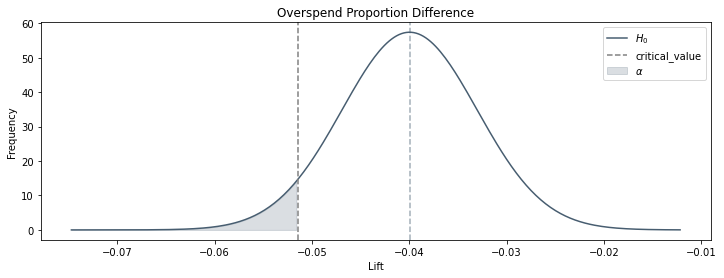

In [234]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_null_distribution(ax, effect_size, overspend_se, alpha, 'smaller', title='Overspend Proportion Difference');

In [235]:
overspend_diff_in_proportions = experiment_stratified.treatment.mean() - experiment_stratified.control.mean()
overspend_diff_in_proportions

-0.06340824927580357

In [236]:
def plot_null_with_alternate_distribution(ax, effect_size, se, alpha, alternative, title, diff_in_proportions):
    h0_dist = plot_null_distribution(ax, effect_size, se, alpha, alternative, title)
    ha_dist = stats.norm(loc=diff_in_proportions, scale=se)
    t = np.linspace(diff_in_proportions - 4*se, diff_in_proportions + 4*se, num=250)
    
    ax.plot(t, ha_dist.pdf(t), label=r'$H_a$')
    ax.axvline(diff_in_proportions, linestyle='--', alpha=0.5)
    
    
    t_stat = (diff_in_proportions - effect_size)/se
    p_val = stats.norm(0, 1).cdf(-abs(t_stat))
    ax.scatter(diff_in_proportions, h0_dist.pdf(diff_in_proportions), marker='o', s=50 )
    ax.text(diff_in_proportions , h0_dist.pdf(diff_in_proportions), s=f'p-val = {p_val}' , 
            color=color_lst[0])
    
    ax.legend()
    
    rejct_null = p_val <= alpha
    print(f'Reject null hypothesis:', rejct_null)

    
    
    

Reject null hypothesis: True


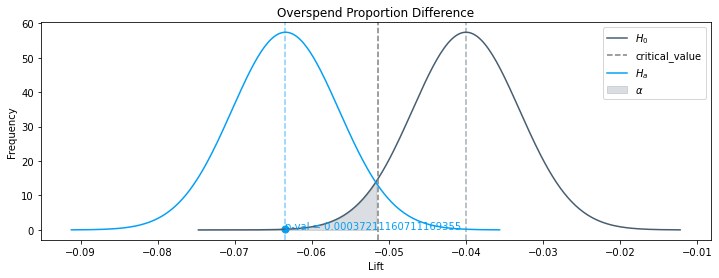

In [237]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_null_with_alternate_distribution(ax, effect_size, overspend_se, alpha, 'smaller',
                                      'Overspend Proportion Difference',
                                      overspend_diff_in_proportions)



### Bootstrap Verification

In [255]:
def plot_hist_dist(
    df, 
    col_to_evaluate,  
    n_bootstrap_samples=10000,
    level=0, 
    stat='mean',
    lift = 'positive',
    **kwargs):
    
    bootstrap_stats = generate_boootstrap_sample_stats(
        df, col_to_evaluate, n_bootstrap_samples, level, **kwargs)
    
    
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    
    bootstrap_stats[['treatment', 'control']].plot(kind = 'kde', ax=axs[0])
    
    col_name = ' '.join(col_to_evaluate.split('_'))
    axs[0].set_xlabel(col_name)
    
    
    bootstrap_stats['diff'] = (bootstrap_stats.treatment - bootstrap_stats.control)\
                                 /bootstrap_stats.control * 100 

    
    bootstrap_stats['diff'].plot(kind = 'kde', ax=axs[1], color=color_lst[3])
    
    axs[1].set_xlabel('% diff')
    
    if lift == 'negative':
        p = (bootstrap_stats['diff'] < 0).sum()/ len(bootstrap_stats)
        print(f'Treatment has a better performance than the control on {col_name} {p*100:.2f}% of the time.')

    elif lift == 'positive':
        p = (bootstrap_stats['diff'] > 0).sum()/ len(bootstrap_stats)
        print(f'Treatment has a better performance than the control on {col_name} {p*100:.2f}% of the time.')

    
    

Treatment has a better performance than the control on overspend 100.00% of the time.


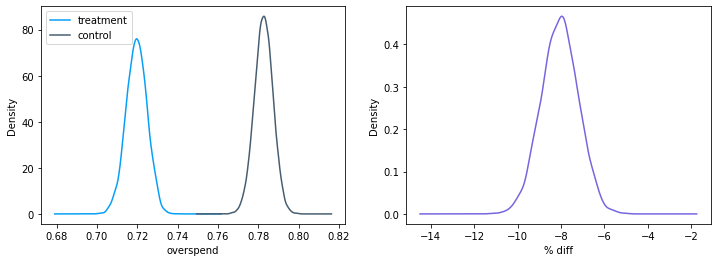

In [256]:
plot_hist_dist(
    df=experiment, 
    col_to_evaluate='overspend',  
    n_bootstrap_samples=10000,
    level=0, 
    stat='mean',
    lift = 'negative',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])

### Does Effectiveness Depend on Company Size
conducting a separate verification

Treatment has a better performance than the control on overspend 100.00% of the time.


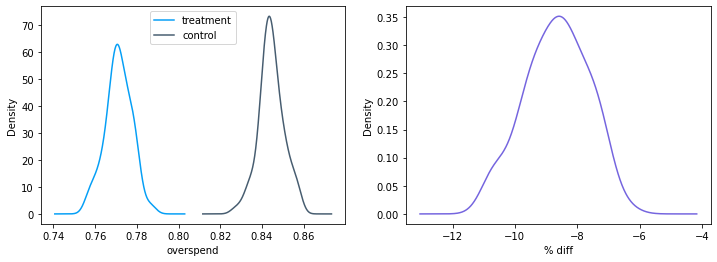

In [257]:
plot_hist_dist(
    df=experiment, 
    col_to_evaluate='overspend',  
    n_bootstrap_samples=100,
    level=1, 
    stat='mean',
    lift = 'negative',
    company_size='small')


Treatment has a better performance than the control on overspend 98.00% of the time.


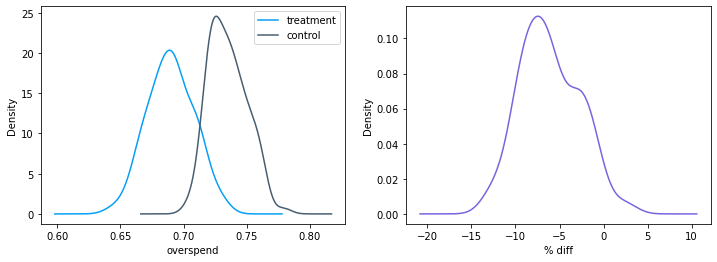

In [259]:
plot_hist_dist(
    df=experiment, 
    col_to_evaluate='overspend',  
    n_bootstrap_samples=100,
    level=1, 
    stat='mean',
    lift = 'negative',
    company_size='medium')


Treatment has a better performance than the control on overspend 100.00% of the time.


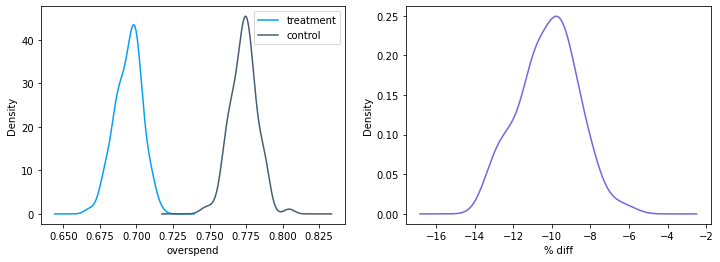

In [261]:
plot_hist_dist(
    df=experiment, 
    col_to_evaluate='overspend',  
    n_bootstrap_samples=100,
    level=1, 
    stat='mean',
    lift = 'negative',
    company_size='large')


## Difference in Overspend Amount Mean Hypothesis Testing

$H_0$: $\mu_{control}$ - $\mu_{treatment}$ ≤ 0 <br>
$H_a$: $\mu_{control}$ - $\mu_{treatment}$ > 0

In other words, 
$H_a$: $\mu_{treatment}$ = $\mu_{control}$ , therfore hypothesized effect is 0

In [242]:
def compute_se_diff_in_means(nobs_control, var_control, nobs_treatment, var_treatment):
    return np.sqrt((var_control/nobs_control) + (var_treatment/nobs_treatment))

In [243]:
experiment_stratified = generate_boootstrap_sample_stats(
    df=experiment, 
    col_to_evaluate='overspend_amt',  
    n_bootstrap_samples=100,
    level=0, 
    stat = 'variance',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])

overspend_amt_se = compute_se_diff_in_means(experiment_stratified.control_size.mean(),
                                            experiment_stratified.control.mean(),
                                            experiment_stratified.treatment_size.mean(), 
                                            experiment_stratified.treatment.mean(),)
overspend_amt_se


60.916740808226116

In [244]:
experiment_stratified = generate_boootstrap_sample_stats(
    df=experiment, 
    col_to_evaluate='overspend_amt',  
    n_bootstrap_samples=100,
    level=0, 
    stat = 'mean',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])

overspend_amt_diff_in_means = experiment_stratified.treatment.mean() - experiment_stratified.control.mean()
overspend_amt_diff_in_means

37.81117645256927

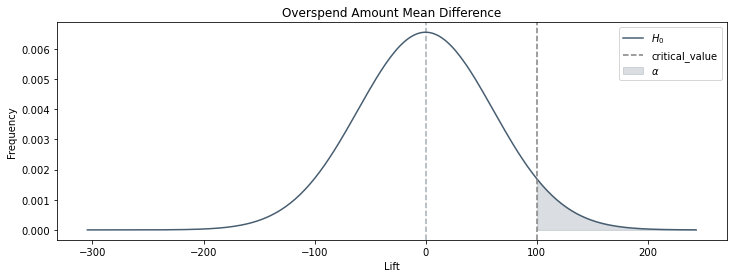

In [245]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_null_distribution(ax, 0, overspend_amt_se, alpha, 'larger', 'Overspend Amount Mean Difference');

Reject null hypothesis: False


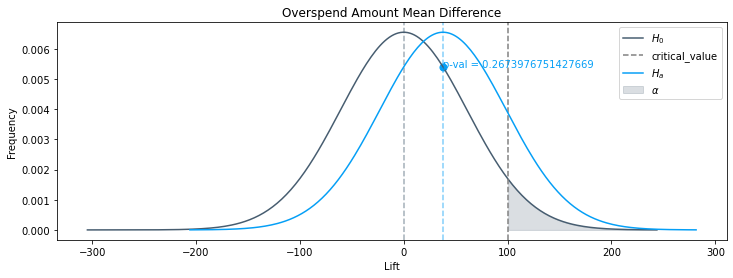

In [246]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_null_with_alternate_distribution(ax, 0, overspend_amt_se, alpha, 'larger', 
                                      'Overspend Amount Mean Difference', overspend_amt_diff_in_means)



Treatment has a better performance than the control on overspend amt 23.34% of the time.


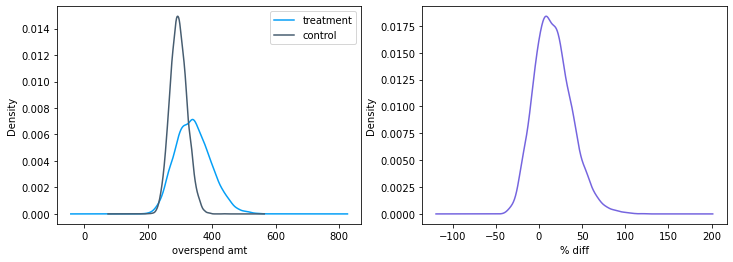

In [262]:
plot_hist_dist(
    df=experiment, 
    col_to_evaluate='overspend_amt',  
    n_bootstrap_samples=10000,
    level=0, 
    stat='mean',
    lift='negative',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])


## [Part 2. Q3.] Wariness on New Product

$H_0$: $\mu_{treatment}$ - $\mu_{control}$  ≥ 0 <br>
$H_a$: $\mu_{treatment}$ - $\mu_{control}$ < 0

### Difference in Campaign Budget Allocation Mean Hypothesis Testing

In [267]:
experiment_stratified = generate_boootstrap_sample_stats(
    df=experiment, 
    col_to_evaluate='campaign_budget',  
    n_bootstrap_samples=1000,
    level=0, 
    stat = 'variance',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])

budget_se = compute_se_diff_in_means(experiment_stratified.control_size.mean(),
                                            experiment_stratified.control.mean(),
                                            experiment_stratified.treatment_size.mean(), 
                                            experiment_stratified.treatment.mean(),)
budget_se


1604.1286550269615

In [268]:
experiment_stratified = generate_boootstrap_sample_stats(
    df=experiment, 
    col_to_evaluate='campaign_budget',  
    n_bootstrap_samples=1000,
    level=0, 
    stat = 'mean',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])

budget_diff_in_means = experiment_stratified.treatment.mean() - experiment_stratified.control.mean()
budget_diff_in_means

2342.4665406111126

Reject null hypothesis: False


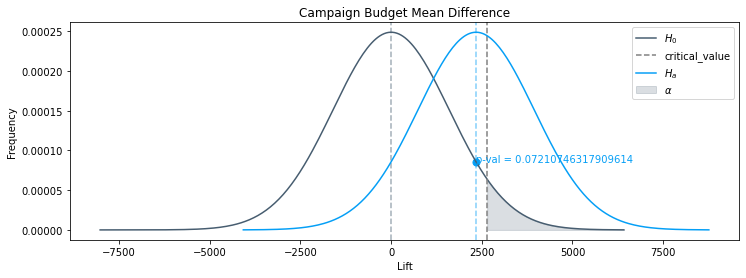

In [269]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_null_with_alternate_distribution(ax, 0, budget_se, alpha, 'larger', 'Campaign Budget Mean Difference',
                                      budget_diff_in_means)



Treatment has a better performance than the control on campaign budget 95.92% of the time.


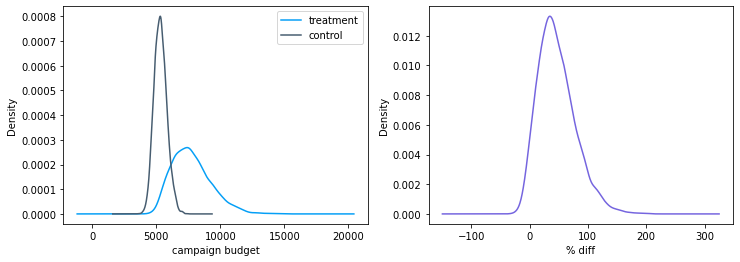

In [266]:
plot_hist_dist(
    df=experiment, 
    col_to_evaluate='campaign_budget',  
    n_bootstrap_samples=10000,
    level=0, 
    stat='mean',
    lift='positive',
    sample_size=sample_size_per_variant, 
    strata_proportions=[1/3, 1/3, 1/3])
